<a href="https://colab.research.google.com/github/mrshamshir/Pneumonia-Classification/blob/main/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

Acknowledgements: Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

## Preprocess


In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
!mkdir Data
!unzip /content/drive/MyDrive/rsna-pneumonia-detection-challenge.zip -d Data/

In [4]:
labels = pd.read_csv("/content/Data/stage_2_train_labels.csv")

In [5]:
print(labels.shape)
labels.head(6)

(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Note that subjects may occur multiple times in the dataset because different pneumonia spots are handled indivually. For our classification task, we can remove those duplicates as we are only interested in the binary label.

In [6]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")
print(labels.shape)
labels.head(6)

(26684, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


In [7]:
ROOT_PATH = Path("/content/Data/stage_2_train_images")
SAVE_PATH = Path("Processed/")

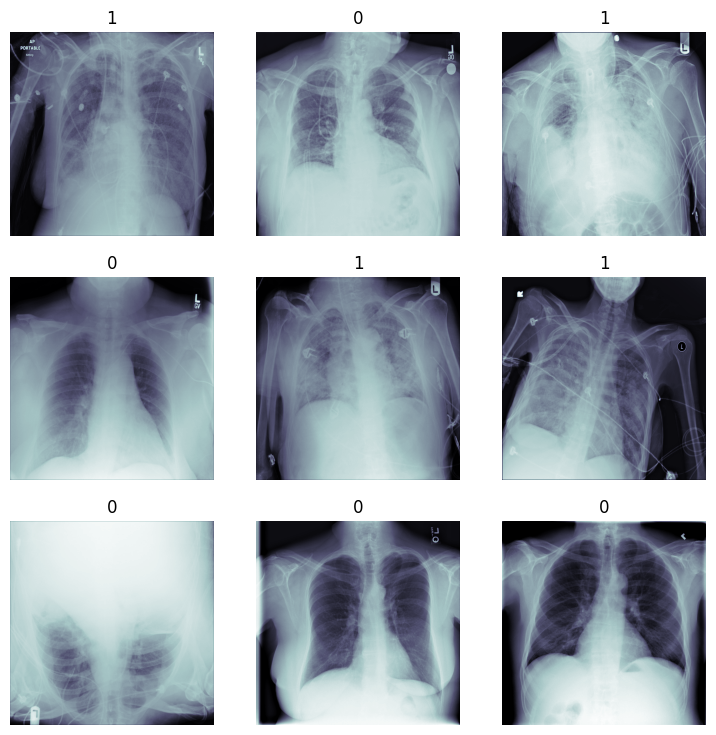

In [22]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 100
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array

        label = labels["Target"].iloc[c]
        axis[i][j].axis('off')
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

In [8]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    # Retrieve the corresponding label
    label = labels.Target.iloc[c]

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val"

    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [9]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

We will use mean and std later in the dataloader to normalize our data

In [10]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.4903962485384803, STD: 0.24795070634161256


## Train

In [ ]:
!pip install torchmetrics
!pip install pytorch_lightning

In [12]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def load_file(path):
    return np.load(path).astype(np.float32)

We pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [14]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(mean, std),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1),antialias=True)

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(mean, std),  # Use mean and std from preprocessing notebook
])

In [15]:
train_dataset = torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)

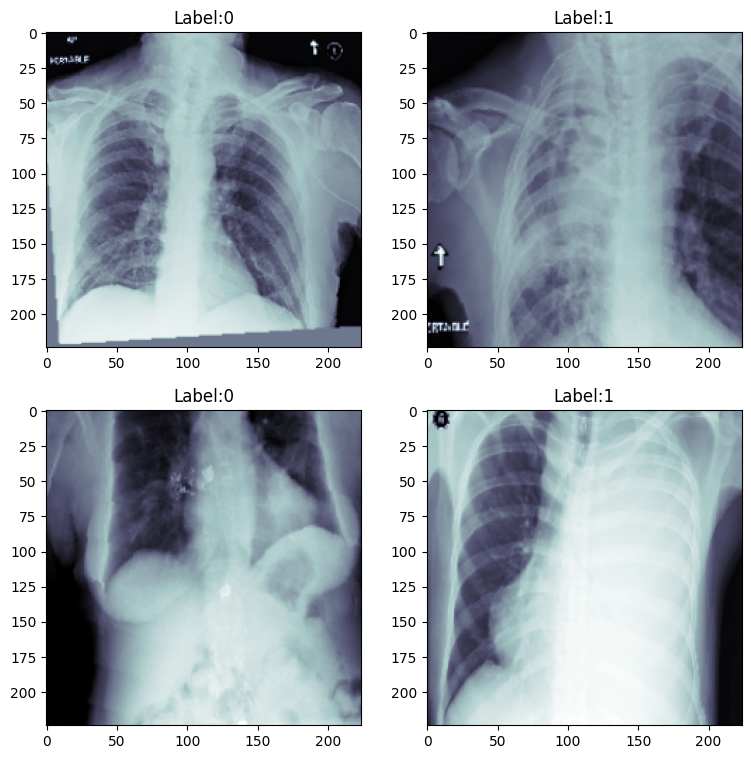

In [38]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [16]:
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [17]:
print('train dataset', np.unique(train_dataset.targets, return_counts=True))
print('test dataset', np.unique(val_dataset.targets, return_counts=True))

train dataset (array([0, 1]), array([18593,  5407]))
test dataset (array([0, 1]), array([2079,  605]))


In [37]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task = 'binary')
        self.val_acc = torchmetrics.Accuracy(task = 'binary')

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss


    def on_train_epoch_end(self):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())


    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)

        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_validation_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())

    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [38]:
model = PneumoniaModel(3)  # Instanciate the model

In [39]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=35,
    mode='max')

In [40]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

trainer = pl.Trainer(accelerator="auto",
                    logger=TensorBoardLogger(save_dir="/content/drive/MyDrive/output"),
                    log_every_n_steps=1,
                    callbacks=checkpoint_callback,
                    max_epochs=35)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


## Evaluation

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("/content/drive/MyDrive/output/lightning_logs/version_0/checkpoints/epoch=34-step=13125.ckpt")
model.eval()
model.to(device);

In [43]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

In [47]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary')(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.7865126729011536
Val Precision: 0.5160320401191711
Val Recall: 0.8512396812438965
Confusion Matrix:
 tensor([[1596,  483],
        [  90,  515]])
Confusion Matrix 2:
 tensor([[1191,  888],
        [  26,  579]])


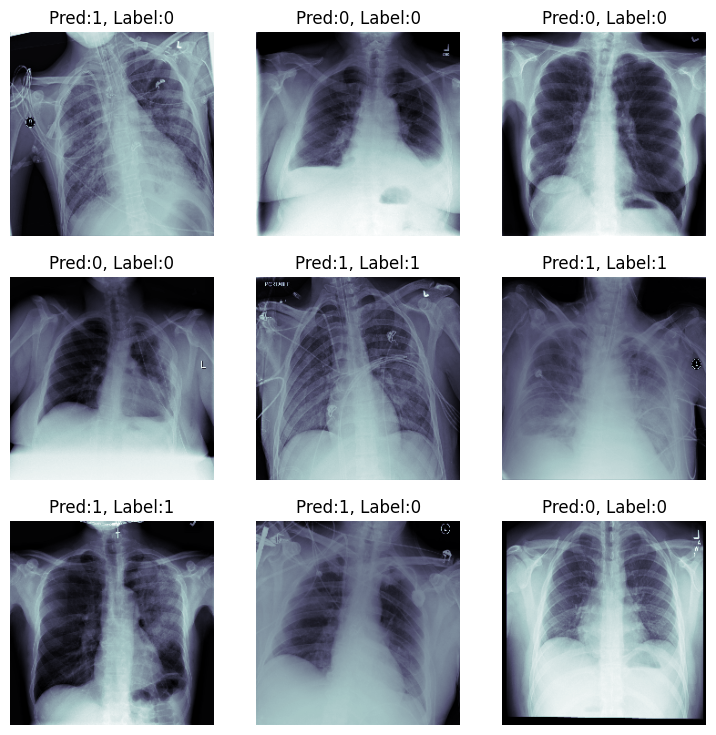

In [54]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")
